## Investigate to what $M_{\rm ext}$ and $R_{\rm ext}$ we are sensitive to

In [1]:
import sys
sys.path.append("/Users/yuhanyao/Documents/Github/AT2019dge/playground/")

import numpy as np
import pandas as pd
import astropy.constants as const
from helper.models_piro2020 import model_piro20

from query_marshal import mylinear_fit

fs= 14
import matplotlib
matplotlib.rcParams['font.size']=fs
import matplotlib.pyplot as plt

In [2]:
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
d_pc = cosmo.luminosity_distance([0.0213])[0].value * 1e+6 # in pc

### Light Curve Zoom with ProgramID

In [3]:
tb = pd.read_csv("../../data/photometry/P48/det_program.csv")
tb = tb.drop(columns=["diffimgname", "psfimgname", "jdobs"])
tb["phase"] = tb["mjd"].values - 58583.2
ix = tb["Fratio"] > 3*tb["Fratio_unc"]
tb = tb[ix]
tb["snr"] = tb["Fratio"].values / tb["Fratio_unc"].values
tb["mag"] = -2.5 * np.log10(tb["Fratio"].values)
tb["emag"] = 2.5 / np.log(10) * tb["Fratio_unc"].values / tb["Fratio"].values

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


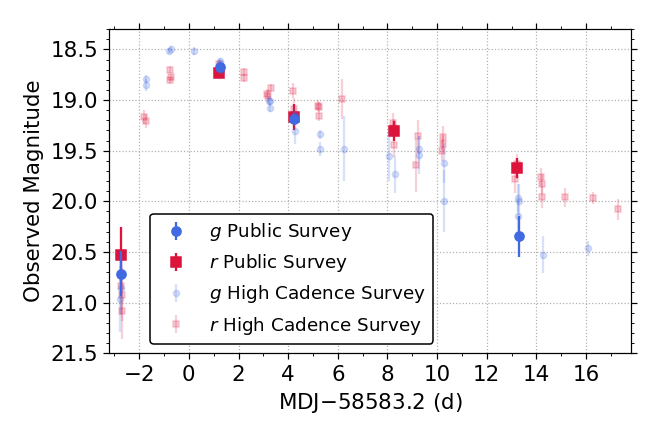

In [5]:
pids = [1,2]
markersizes = [6,4]
fids = [1,2]
colors = ["royalblue", "crimson"]
markers = ["o", "s"]
alphas = [1, 0.2]

plt.figure(figsize = (6, 4))
ax = plt.subplot(111)
for i in range(len(pids)):
    pid = pids[i]
    markersize = markersizes[i]
    subtb = tb[tb.programid==pid]
    alpha = alphas[i]
    for j in range(len(fids)):
        fid = fids[j]
        color = colors[j]
        marker = markers[j]
        subsubtb = subtb[subtb.filterid==fid]
        xx = subsubtb["phase"].values
        yy = subsubtb["mag"].values
        eyy = subsubtb["emag"].values
        if pid==1 and fid==1:
            mylabel = "$g$ Public Survey"
        if pid==1 and fid==2:
            mylabel = "$r$ Public Survey"
        if pid==2 and fid==1:
            mylabel = "$g$ High Cadence Survey"
        if pid==2 and fid==2:
            mylabel = "$r$ High Cadence Survey"
        ax.errorbar(xx, yy, eyy, fmt = ".", marker = marker, markersize=markersize, 
                    color = color, alpha = alpha, label = mylabel, zorder = 3-j)
ax.set_xlim(-3.2, 17.8)
ax.set_ylim(21.5, 18.3)
ax.grid(ls = ":")

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.tick_params(which = 'major', length = 4, top=True, right=True)
ax.tick_params(which = 'minor', length = 2, top=True, right=True)

ax.set_ylabel("Observed Magnitude")
ax.set_xlabel("MDJ$-58583.2$ (d)")

ax.legend(ncol = 1, fontsize = fs-2, frameon = True, 
          fancybox = True, bbox_to_anchor=(0.35, 0.), loc = "lower center", edgecolor = "k", framealpha=1)

plt.tight_layout()
# plt.savefig("../../paper/figures/lc_programids.pdf")

In [8]:
tb1 = tb[tb.programid==1]

In [9]:
tbr = tb1[tb1.filterid == 2]
tbg = tb1[tb1.filterid == 1]

tbr = tbr[tbr.phase>=0]
tbr = tbr[tbr.phase<=14]

tbg = tbg[tbg.phase>=0]
tbg = tbg[tbg.phase<=14]

In [10]:
mylinear_fit(tbr["phase"].values, tbr["mag"].values, np.ones(len(tbr)))

(0.07217686066879099, 0.11108580602581204, 18.73437083325344)

In [11]:
mylinear_fit(tbg["phase"].values, tbg["mag"].values, np.ones(len(tbg)))

(0.13678898653487076, 0.11282236998348345, 18.54335818340439)

In [12]:
1.208646 - (-2.731597)

3.9402429999999997

In [13]:
1.256597 - (-2.752257)

4.008854

### Shock Cooling Modelling

In [19]:
tgrid = np.linspace(0.2, 8, 781)

In [20]:
tgrid = np.linspace(0.1, 8, 791)
R_exts = np.linspace(3e+12, 5e+13, 95)
M_exts = np.linspace(0.01, 0.22, 22)
wvg = 4813.97
wvr = 6421.81
wvs = np.array([wvg, wvr])
mpeaks = np.zeros((len(R_exts), len(M_exts), len(wvs))) # g and r
trises = np.zeros((len(R_exts), len(M_exts), len(wvs))) # g and r
trises_ = np.zeros((len(R_exts), len(M_exts), len(wvs))) # g and r

In [21]:
mpeaks.shape

(95, 22, 2)

In [22]:
for i in range(len(R_exts)):
    for j in range(len(M_exts)):
        for k in range(len(wvs)):
            wave = wvs[k]
            freq = const.c.cgs.value / (wave * 1e-8)
            mymodel = model_piro20(tgrid, wave, Renv=R_exts[i], Menv_=M_exts[j], Eext49 = 5.3)
            mymodel = mymodel / (4 * np.pi * (10 * const.pc.cgs.value)**2) # erg/s/cm^2/AA
            mymodel = mymodel*wave # erg/s/cm^2 
            mymodel = mymodel/freq # erg/s/cm^2/Hz
            f0 = 3631e-23
            fratio = mymodel / f0
            id_peak = np.argsort(fratio)[-1]
            fratio_peak = fratio[id_peak]
            m_peak = -2.5*np.log10(fratio_peak)
            t_peak = tgrid[id_peak]
            tgrid_rise = tgrid[:id_peak]
            fratio_rise = fratio[:id_peak]
            mpeaks[i, j, k] = m_peak
            
            # 0.75 mag
            id_half = np.argsort(abs(fratio_rise - 0.5*fratio_peak))[0]
            fratio_half = fratio_rise[id_half]
            t_half = tgrid_rise[id_half]
            trise = t_peak - t_half
            #print (m_peak, trise)
            trises[i, j, k] = trise
            
            # 1.5 mag
            id_qua = np.argsort(abs(fratio_rise - 0.25*fratio_peak))[0]
            fratio_qua = fratio_rise[id_qua]
            t_qua = tgrid_rise[id_qua]
            trise_ = t_peak - t_qua
            trises_[i, j, k] = trise_

/Users/yuhanyao/Documents/Github/AT2019dge/playground/helper/mcmcfit.py:32: RuntimeWarning: overflow encountered in exp
  Blambda = (2. * const.h.cgs.value * const.c.cgs.value**2 ) /  (lamb2**5. ) / (np.exp(x) - 1. )


In [23]:
X, Y = np.meshgrid(M_exts, R_exts)

<IPython.core.display.Javascript object>


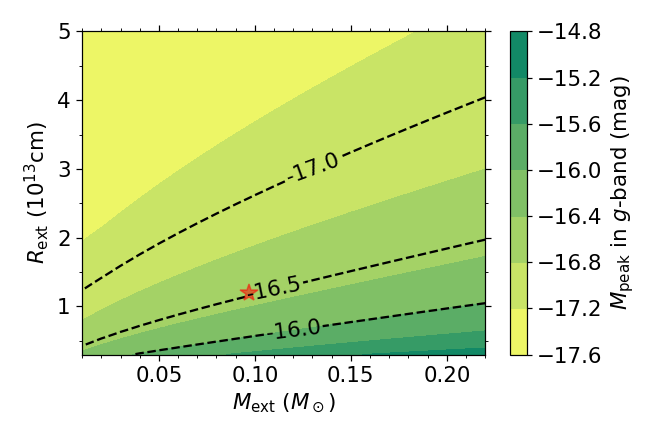

In [24]:
fig = plt.figure(figsize = (6, 4))
ax = plt.subplot(111)
cp = ax.contourf(X, Y/1e+13, mpeaks[:,:,0],  # [-18, -17, -16, -15],
                 origin = "lower", zorder = 1, cmap = plt.cm.summer_r)
cp2 = ax.contour(X, Y/1e+13, mpeaks[:,:,0], levels=[-17, -16.5, -16], origin = "lower", 
                 zorder = 2, colors = "k")
ax.clabel(cp2, cp2.levels, inline=True, fmt="%.1f", fontsize=fs)
ax.set_xlim(M_exts[0], M_exts[-1])
ax.set_ylim(R_exts[0]/1e+13, R_exts[-1]/1e+13)
cbar = fig.colorbar(cp)
ax.set_xlabel(r"$M_{\rm ext}$"+" ("+r"$M_\odot$"+")")
ax.set_ylabel(r"$R_{\rm ext}$"+" ("+r"$10^{13}$"+"cm)")
cbar.ax.set_ylabel(r"$M_{\rm peak}$"+" in $g$-band (mag)")

ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.tick_params(which = 'major', length = 4, top=True, right=True)
ax.tick_params(which = 'minor', length = 2, top=True, right=True)

ax.plot(0.0971, 1.19, color = 'r', zorder = 3, marker = "*", markersize= 12, alpha = 0.5)
plt.tight_layout()
plt.savefig("../../paper/figures/cooling_Mpeak.pdf")

<IPython.core.display.Javascript object>


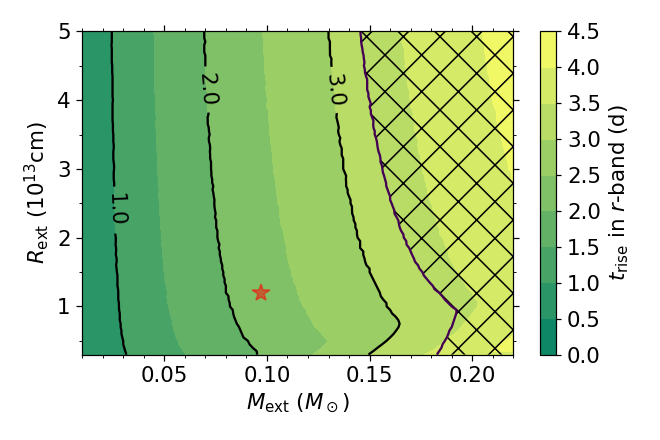

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'color'
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'color'
  


In [26]:
fig = plt.figure(figsize = (6, 4))
ax = plt.subplot(111)
cp = ax.contourf(X, Y/1e+13, trises[:,:,1],# [-18, -17, -16, -15],
                 origin = "lower", zorder = 1, cmap = plt.cm.summer)
cp2 = ax.contour(X, Y/1e+13, trises[:,:,1], levels=[1, 2, 3], origin = "lower", 
                 zorder = 2, colors = "k")
ax.contourf(X, Y/1e+13, trises_[:,:,1], levels=[4.1, 1e+3], origin = "lower", hatches=['x'], alpha = 0., color = "k")
ax.contour(X, Y/1e+13, trises_[:,:,1], levels=[4.1, 1e+3], origin = "lower", color = "k")

ax.clabel(cp2, cp2.levels, inline=True, fmt="%.1f", fontsize=fs)
ax.set_xlim(M_exts[0], M_exts[-1])
ax.set_ylim(R_exts[0]/1e+13, R_exts[-1]/1e+13)
cbar = fig.colorbar(cp)

ax.set_xlabel(r"$M_{\rm ext}$"+" ("+r"$M_\odot$"+")")
ax.set_ylabel(r"$R_{\rm ext}$"+" ("+r"$10^{13}$"+"cm)")
cbar.ax.set_ylabel(r"$t_{\rm rise}$"+" in $r$-band (d)")

ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.tick_params(which = 'major', length = 4, top=True, right=True)
ax.tick_params(which = 'minor', length = 2, top=True, right=True)

ax.plot(0.0971, 1.19, color = 'r', zorder = 3, marker = "*", markersize= 12, alpha = 0.5)
plt.tight_layout()
plt.savefig("../../paper/figures/cooling_trise.pdf")

In [14]:
-16.5 + 2.5 * np.log10((100e+6 / 10)**2)

18.5

In [16]:
-16.5 + 2.5 * np.log10((150e+6 / 10)**2)

19.380456295278407